### TopK Sparse Autoencoder for Protein-Ligand Docking Analysis

**Goal**: Train a TopK Sparse Autoencoder on 30D VAE latent vectors to identify interpretable features distinguishing native-like poses (RMSD <2Å) from poor poses (RMSD >2Å).

**Data**: ~6,000-7,000 poses per protein system, filtered to generations 0-7
This version uses ~all cases (scaled up)

In [1]:
# Imports and setup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from scipy.stats import spearmanr
from typing import Optional
import pickle
import glob
import os
import wandb
from pathlib import Path

from schrodinger.structure import StructureReader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Matplotlib inline for Jupyter
%matplotlib inline

# Set style for light mode
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'text.color': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.edgecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'white',
    'axes.titlecolor': 'black',  # Plot titles in black
})

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: NVIDIA RTX A4500


### Data Extraction & Consolidation

1. initial scan and inventory
2. extact metadata
3. create unified dataset

In [2]:
# Cell 1: Imports and setup
import sys
import os
sys.path.append(os.path.expanduser('~/projects'))

from src.config import ROOT_DIR, OUTPUT_DIR, EXCLUSION_LIST, LATENT_DIM
from src.data_processor import process_all_cases, load_processed_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
stats, latents_raw, metadata = process_all_cases(
    root_dir=ROOT_DIR,
    output_dir=OUTPUT_DIR,
    exclusion_list=EXCLUSION_LIST,
    latent_dim=LATENT_DIM
)

[SKIP] Excluded: hsp90_2bt0_hsp90_2ccu
Found 49 valid cases

Processing cases...


  2%|▏         | 1/49 [00:56<45:09, 56.44s/it]

[!] No valid data for alr2_1iei_alr2_2ikj
[!] No valid data for alr2_2fzd_alr2_1z3n


 12%|█▏        | 6/49 [03:37<27:14, 38.02s/it]

[!] No valid data for cdk2_1pxi_cdk2_2c6k


 16%|█▋        | 8/49 [04:27<21:56, 32.10s/it]

[!] No valid data for chk1_2brb_chk1_2e9n


 33%|███▎      | 16/49 [10:02<23:47, 43.27s/it]

[!] No valid data for er_1yy4_er_1u3r
[!] No valid data for fxa_1wu1_fxa_1lpg


 49%|████▉     | 24/49 [15:05<17:54, 42.97s/it]

[!] No valid data for hsp90_2fwz_hsp90_1uy6


 55%|█████▌    | 27/49 [16:30<13:00, 35.50s/it]

[!] No valid data for pdk_3rwp_pdk_3sc1


 59%|█████▉    | 29/49 [17:09<09:40, 29.03s/it]

[!] No valid data for pim1_1yi3_pim1_4bzo


 67%|██████▋   | 33/49 [19:24<08:52, 33.27s/it]

[!] No valid data for pim1_3vbx_pim1_4bzn


 78%|███████▊  | 38/49 [22:33<07:24, 40.43s/it]

[!] No valid data for ptp1b_1wax_ptp1b_1c84


 84%|████████▎ | 41/49 [23:47<04:24, 33.02s/it]

[!] No valid data for rock1_5kks_rock1_5wng


 96%|█████████▌| 47/49 [27:33<01:20, 40.45s/it]

[!] No valid data for upa_1c5y_upa_1gj9


100%|██████████| 49/49 [28:09<00:00, 34.49s/it]



Consolidating data...
Computing statistics...

Dataset Statistics
Total samples: 435,069
Total cases: 36
Samples per case (avg): 12085.2

RMSD percentiles: {'p25': 3.0533796759763847, 'p50': 4.971065901724191, 'p75': 7.242218566248323, 'p90': 9.305076110245523}
Energy percentiles: {'p10': -14406.326810738274, 'p25': -10945.55718710387, 'p50': -9669.765668996743, 'p75': 10000.0}

Latent statistics:
  Mean range: [-1.069, 1.201]
  Std range: [2.342, 4.348]

Pose Quality:
  Good poses (< 2Å): 53495 (12.3%)
  Poor poses (≥ 2Å): 381574 (87.7%)

Saving data...
✓ Saved arrays to processed_data/dataset.npz
✓ Saved metadata to processed_data/metadata.csv
✓ Saved stats to processed_data/stats.pkl

✓ Processing complete!


In [3]:
# Cell 3: OR load already-processed data (faster for re-runs)
latents_normalized, metadata, stats = load_processed_data(OUTPUT_DIR)

Loaded 435,069 samples from processed_data


In [4]:
# Quick inspection
print(f"Latent shape: {latents_raw.shape}")
print(f"Metadata shape: {metadata.shape}")
metadata.head()

NameError: name 'latents_raw' is not defined

In [5]:
# Per-case statistics

case_stats = metadata.groupby('case_id').agg({
    'rmsd': ['mean', 'min', 'max'],
    'energy': ['mean', 'min', 'max'],
    'sample_idx': 'count'
}).round(2)
case_stats.columns = ['_'.join(col) for col in case_stats.columns]
case_stats = case_stats.rename(columns={'sample_idx_count': 'n_samples'})
case_stats.sort_values('n_samples', ascending=False)

,rmsd_mean,rmsd_min,rmsd_max,energy_mean,energy_min,energy_max,n_samples
case_id,,,,,,,
ptp1b_1no6_ptp1b_1pyn,6.030000e+00,1.23,2.400820e+03,5.509435e+04,-12017.83,3.022578e+08,12745
ptp1b_1c84_ptp1b_1xbo,6.770000e+00,0.29,8.808510e+03,3.445897e+04,-12510.73,1.555724e+08,12735
gsk3b_3sd0_gsk3b_4ach,6.620000e+00,0.66,1.132860e+03,2.125352e+04,-13401.99,2.412209e+08,12731
pim1_4lmu_pim1_4bzo,4.710000e+00,0.30,2.113000e+01,-5.910770e+03,-10816.74,1.000000e+04,12730
bace1_5clm_bace1_5ezx,4.390000e+00,0.68,3.314590e+03,7.748167e+04,-14406.35,5.430545e+08,12720
chk1_2brb_chk1_2hxl,3.340000e+00,0.58,1.242000e+01,-6.408070e+03,-10881.88,1.000000e+04,12715
ask1_4bhn_ask1_4bie,5.150000e+00,0.67,1.714000e+01,-6.889040e+03,-10036.35,1.000000e+04,12711
cdk2_1pxj_cdk2_2btr,5.930000e+00,0.23,2.281000e+01,-4.950030e+03,-10940.15,1.000000e+04,12706
pim1_2xiz_pim1_4lmu,5.440000e+00,0.28,1.454200e+02,3.882605e+06,-11315.47,3.800396e+10,12704


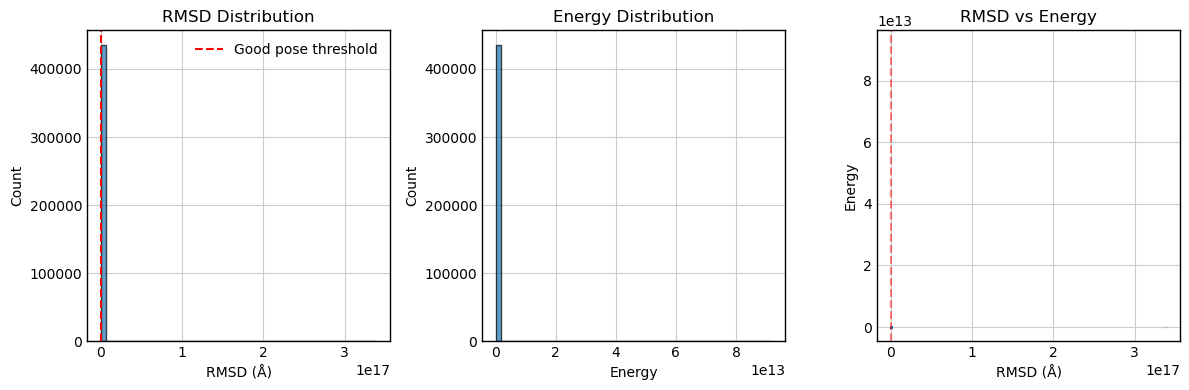

In [6]:
# Visualize RMSD distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(metadata['rmsd'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(2.0, color='red', linestyle='--', label='Good pose threshold')
plt.xlabel('RMSD (Å)')
plt.ylabel('Count')
plt.title('RMSD Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(metadata['energy'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Energy')
plt.ylabel('Count')
plt.title('Energy Distribution')

plt.subplot(1, 3, 3)
plt.scatter(metadata['rmsd'], metadata['energy'], alpha=0.1, s=1)
plt.axvline(2.0, color='red', linestyle='--', alpha=0.5)
plt.xlabel('RMSD (Å)')
plt.ylabel('Energy')
plt.title('RMSD vs Energy')

plt.tight_layout()
plt.show()

### Preprocessing: Normalization and Train/Val Splits
   - Split by case (no data leakage)
   - ~70% train, 15% val, 15% test


In [ ]:
# Create train/val/test splits (by case to avoid leakage)
from sklearn.model_selection import train_test_split

case_ids = metadata['case_id'].unique()
print(f"Total cases: {len(case_ids)}")

# 70% train, 15% val, 15% test
train_cases, test_cases = train_test_split(case_ids, test_size=0.15, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 0.15

print(f"Train cases: {len(train_cases)} ({len(train_cases)/len(case_ids)*100:.1f}%)")
print(f"Val cases: {len(val_cases)} ({len(val_cases)/len(case_ids)*100:.1f}%)")
print(f"Test cases: {len(test_cases)} ({len(test_cases)/len(case_ids)*100:.1f}%)")

# Get indices for each split
train_idx = metadata[metadata['case_id'].isin(train_cases)]['global_idx'].values
val_idx = metadata[metadata['case_id'].isin(val_cases)]['global_idx'].values
test_idx = metadata[metadata['case_id'].isin(test_cases)]['global_idx'].values

print(f"\nTrain samples: {len(train_idx):,}")
print(f"Val samples: {len(val_idx):,}")
print(f"Test samples: {len(test_idx):,}")

# Save splits
np.savez(
    f'{OUTPUT_DIR}/splits.npz',
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    train_cases=train_cases,
    val_cases=val_cases,
    test_cases=test_cases
)
print(f"\n✓ Saved splits to {OUTPUT_DIR}/splits.npz")

Total cases: 36
Train cases: 24 (66.7%)
Val cases: 6 (16.7%)
Test cases: 6 (16.7%)

Train samples: 294,851
Val samples: 71,604
Test samples: 68,614

✓ Saved splits to ./processed_data/splits.npz


### DataLoader
- efficient batching
- automatic shuffling
- GPU-optimized loading

In [14]:
import sys
from pathlib import Path
import os
sys.path.append(os.path.expanduser('~/projects'))

from src.data_processor import load_processed_data
from src.dataloader import create_dataloaders
from src.config import OUTPUT_DIR

# Load processed data
latents, metadata, stats = load_processed_data(OUTPUT_DIR)

# Hyperparameters
batch_size = 256  # Using your batch size
lr = 1e-3
max_epochs = 100
k_values = [1, 3, 6, 8, 15, 20, 30]
# 1 (1/120, 99.2%)
# 3 (3/120, 97.5%)
# 6 is most sparse (6/120, 95% sparsity) 
# 8 is very sparse (8/120, 93% sparsity) 
# 15 is less sparse (15/120, 87.5% sparsity)
# 20 is more dense (20/120, 83.3% sparsity)
# 30 is least sparse (30/120, 75% sparsity)
hidden_dim = 120
input_dim = 30

# Replace your dataloader creation with this:
print("Loading all data into memory for faster training...")

# Load processed data
latents, metadata, stats = load_processed_data(OUTPUT_DIR)

# Load splits
splits = np.load(f'{OUTPUT_DIR}/splits.npz')
train_idx = splits['train_idx']
val_idx = splits['val_idx']
test_idx = splits['test_idx']

# Create in-memory tensors (already on device if possible)
X_train = torch.tensor(latents[train_idx], dtype=torch.float32)
X_val = torch.tensor(latents[val_idx], dtype=torch.float32)
X_test = torch.tensor(latents[test_idx], dtype=torch.float32)

# If you have enough GPU memory, move to GPU now
if torch.cuda.is_available() and X_train.nbytes < 2e9:  # If < 2GB
    print("Moving data to GPU...")
    X_train = X_train.to(device)
    X_val = X_val.to(device)
    X_test = X_test.to(device)

print(f"✓ Data loaded into memory")
print(f"  Train: {X_train.shape}, {X_train.nbytes/1e6:.1f} MB")
print(f"  Val: {X_val.shape}, {X_val.nbytes/1e6:.1f} MB")

# Create simple in-memory dataloaders
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, 
                          num_workers=0, pin_memory=False)  # num_workers=0 for in-memory
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, 
                        num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, 
                         num_workers=0, pin_memory=False)

print(f"✓ DataLoaders created (in-memory mode)")

# Directory to save models and histories
model_dir = 'projects/laloo-sae/models/12_21_25'  # models directory in project root
os.makedirs(model_dir, exist_ok=True)

print(f"✓ DataLoaders ready!")
print(f"✓ Models will be saved to: {model_dir}")

Loaded 435,069 samples from processed_data
Loading all data into memory for faster training...
Loaded 435,069 samples from processed_data
Moving data to GPU...
✓ Data loaded into memory
  Train: torch.Size([294851, 30]), 35.4 MB
  Val: torch.Size([71604, 30]), 8.6 MB
✓ DataLoaders created (in-memory mode)
✓ DataLoaders ready!
✓ Models will be saved to: projects/laloo-sae/models/12_21_25


## TopK Sparse Autoencoder Model Definition


In [7]:
import torch.nn.functional as F

class TopKSAE(nn.Module):
    """
    TopK Sparse Autoencoder following InterProT SAE model (Adams et. al 2025)
    Architecture: input -> hidden -> top-k sparsity -> output
    """
    def __init__(self, input_dim=30, hidden_dim=120, k=6, auxk=12, batch_size=256, dead_steps_threshold=2000):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.auxk = auxk
        self.batch_size = batch_size
        self.dead_steps_threshold = dead_steps_threshold / batch_size

        # Encoder / Decoder for weights and biases
        self.w_enc = nn.Parameter(torch.empty(input_dim, hidden_dim))
        self.w_dec = nn.Parameter(torch.empty(hidden_dim, input_dim))
        self.b_enc = nn.Parameter(torch.zeros(hidden_dim))
        self.b_pre = nn.Parameter(torch.zeros(input_dim))

        # Initialize weights
        # Use kaiming initialization for ReLU (default nonlinearity)
        # The 'a' parameter is for leaky_relu negative slope, so we don't need it for ReLU
        nn.init.kaiming_uniform_(self.w_enc, nonlinearity='relu')
        self.w_dec.data = self.w_enc.data.T.clone()
        self.w_dec.data /= self.w_dec.data.norm(dim=0)

        # Track dead neurons
        self.register_buffer("stats_last_nonzero", torch.zeros(hidden_dim, dtype=torch.long))

    def LN(self, x, eps=1e-5):
        """Layer normalization to input tensor"""
        mu = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_norm = (x - mu) / (std + eps)
        return x_norm, mu, std

    def _tie_decoder_weights(self):
        """
        Normalizes the decoder weights to have unit norm.
        This ensures that the magnitude of features is encoded in the activations,
        not the weights.
        """
        self.w_dec.data /= self.w_dec.data.norm(dim=0, keepdim=True)

    def topK_activation(self, x, k):
        """
        Apply top-k activation to the input tensor.

        Args:
            x: (BATCH_SIZE, D_EMBED, D_MODEL) input tensor to apply top-k activation on.
            k: Number of top activations to keep.

        Returns:
            torch.Tensor: Tensor with only the top k activations preserved,and others
            set to zero.

        This function performs the following steps:
        1. Find the top k values and their indices in the input tensor.
        2. Apply ReLU activation to these top k values.
        3. Create a new tensor of zeros with the same shape as the input.
        4. Scatter the activated top k values back into their original positions.
        """
        topk = torch.topk(x, k=k, dim=-1, sorted=False)
        values = F.relu(topk.values)
        out = torch.zeros_like(x)
        out.scatter_(-1, topk.indices, values)
        return out

    def auxk_mask_fn(self):
        """
        Create a mask for dead neurons.

        Returns:
            torch.Tensor: A boolean tensor of shape (D_HIDDEN,) where True indicates
                a dead neuron.
        """
        return self.stats_last_nonzero > self.dead_steps_threshold

    def forward(self, x):
        """
        Forward pass of the Sparse Autoencoder. If there are dead neurons, compute the
        reconstruction using the AUXK auxiliary hidden dims as well.

        Args:
            x: (BATCH_SIZE, D_EMBED, D_MODEL) input tensor to the SAE.

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
                - The reconstructed activations via top K hidden dims.
                - If there are dead neurons, the auxiliary activations via top AUXK
                    hidden dims; otherwise, None.
                - The number of dead neurons.
        """

        # Layer norm + center
        x_norm, mu, std = self.LN(x)
        x_norm = x_norm - self.b_pre

        # Encode
        pre_acts = x_norm @ self.w_enc + self.b_enc

        # Top-K activations
        latents = self.topK_activation(pre_acts, self.k)

        # Update dead neurons
        dead_mask_update = (latents == 0).all(dim=0)
        self.stats_last_nonzero *= dead_mask_update.long()
        self.stats_last_nonzero += 1

        dead_mask = self.auxk_mask_fn()
        num_dead = dead_mask.sum().item()

        # Decode main latents
        recons = latents @ self.w_dec + self.b_pre
        recons = recons * std + mu

        # Auxiliary top-k if dead neurons exist
        if num_dead > 0:
            k_aux = min(x.shape[-1] // 2, num_dead)
            aux_latents = torch.where(dead_mask[None], pre_acts, -torch.inf)
            aux_latents = self.topK_activation(aux_latents, k=k_aux)
            aux_recons = aux_latents @ self.w_dec + self.b_pre
            aux_recons = aux_recons * std + mu
        else:
            aux_recons = None

        return recons, aux_recons, num_dead

    @torch.no_grad()
    def forward_val(self, x):
        """Forward for validation (no auxk, no stats update)"""
        x_norm, mu, std = self.LN(x)
        x_norm = x_norm - self.b_pre
        pre_acts = x_norm @ self.w_enc + self.b_enc
        latents = self.topK_activation(pre_acts, self.k)
        recons = latents @ self.w_dec + self.b_pre
        recons = recons * std + mu
        return recons

    @torch.no_grad()
    def get_acts(self, x):
        """Return latent activations"""
        x_norm, _, _ = self.LN(x)
        x_norm = x_norm - self.b_pre
        pre_acts = x_norm @ self.w_enc + self.b_enc
        latents = self.topK_activation(pre_acts, self.k)
        return latents

    @torch.no_grad()
    def encode(self, x):
        x_norm, mu, std = self.LN(x)
        x_norm = x_norm - self.b_pre
        acts = x_norm @ self.w_enc + self.b_enc
        return acts, mu, std

    @torch.no_grad()
    def decode(self, acts, mu, std):
        latents = self.topK_activation(acts, self.k)
        recons = latents @ self.w_dec + self.b_pre
        recons = recons * std + mu
        return recons

    @torch.no_grad()
    def reset_usage_tracking(self):
        self.stats_last_nonzero.zero_()

def loss_fn(
    x: torch.Tensor, recons: torch.Tensor, auxk: Optional[torch.Tensor] = None
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the loss function for the Sparse Autoencoder.

    Args:
        x: (BATCH_SIZE, D_EMBED, D_MODEL) input tensor to the SAE.
        recons: (BATCH_SIZE, D_EMBED, D_MODEL) reconstructed activations via top K
            hidden dims.
        auxk: (BATCH_SIZE, D_EMBED, D_MODEL) auxiliary activations via top AUXK
            hidden dims. See A.2. in https://arxiv.org/pdf/2406.04093.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: A tuple containing:
            - The MSE loss.
            - The auxiliary loss.
    """
    mse_scale = 1
    auxk_coeff = 1.0 / 32.0  ## why 32?

    mse_loss = mse_scale * F.mse_loss(recons, x)
    if auxk is not None:
        auxk_loss = auxk_coeff * F.mse_loss(auxk, x - recons).nan_to_num(0)
    else:
        auxk_loss = torch.tensor(0.0)
    return mse_loss, auxk_loss

## Training Loop


In [ ]:
# ============================================================================
# Data Loading - IN MEMORY (FAST)
# ============================================================================
print("Loading all data into memory for faster training...")

# Load processed data
latents, metadata, stats = load_processed_data(OUTPUT_DIR)

# Load splits
splits = np.load(f'{OUTPUT_DIR}/splits.npz')
train_idx = splits['train_idx']
val_idx = splits['val_idx']
test_idx = splits['test_idx']

# Create in-memory tensors
X_train = torch.tensor(latents[train_idx], dtype=torch.float32)
X_val = torch.tensor(latents[val_idx], dtype=torch.float32)
X_test = torch.tensor(latents[test_idx], dtype=torch.float32)

# If you have enough GPU memory, move to GPU now
if torch.cuda.is_available() and X_train.nbytes < 2e9:  # If < 2GB
    print("Moving data to GPU...")
    X_train = X_train.to(device)
    X_val = X_val.to(device)
    X_test = X_test.to(device)
    data_on_gpu = True
else:
    data_on_gpu = False

print(f"✓ Data loaded into memory")
print(f"  Train: {X_train.shape}, {X_train.nbytes/1e6:.1f} MB")
print(f"  Val: {X_val.shape}, {X_val.nbytes/1e6:.1f} MB")
print(f"  Data on GPU: {data_on_gpu}")

# Create simple in-memory dataloaders
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=0, pin_memory=False)

print(f"✓ DataLoaders created (in-memory mode)")


# ============================================================================
# Training Function
# ============================================================================
n_runs = 5
base_seed = 42

def train_sae(k, hidden_dim, input_dim, batch_size, lr, max_epochs, run_id=0, seed=None):
    # Set seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    
    # Initialize wandb for this run
    wandb.init(
        project='laloo-sae',
        name=f'topksae_k{k}_run{run_id}',
        reinit=True,
        config={
            'k': k,
            'hidden_dim': hidden_dim,
            'input_dim': input_dim,
            'batch_size': batch_size,
            'lr': lr,
            'max_epochs': max_epochs,
            'run_id': run_id,
            'seed': seed
        }
    )

    # Initialize model
    model = TopKSAE(input_dim=input_dim, hidden_dim=hidden_dim, k=k, auxk=12, 
                    batch_size=batch_size, dead_steps_threshold=2000).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Track losses
    train_losses, val_losses = [], []
    train_mse_losses, train_auxk_losses = [], []
    val_mse_losses, val_auxk_losses = [], []

    # Best model tracking
    best_val_loss = float('inf')
    best_model_state = None

    model.reset_usage_tracking()

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_mse = 0.0
        epoch_train_auxk = 0.0
        n_train_batches = 0
        
        for batch in train_loader:
            # Handle data already on GPU or move to GPU
            if data_on_gpu:
                x = batch[0]  # Already on GPU
            else:
                x = batch[0].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recons, auxk, _ = model(x)
            mse_loss, auxk_loss = loss_fn(x, recons, auxk)
            total_loss = mse_loss + auxk_loss
            total_loss.backward()
            optimizer.step()
            model._tie_decoder_weights()

            epoch_train_loss += total_loss.item()
            epoch_train_mse += mse_loss.item()
            epoch_train_auxk += auxk_loss.item()
            n_train_batches += 1
        
        # Track losses
        avg_train_loss = epoch_train_loss / n_train_batches
        avg_train_mse = epoch_train_mse / n_train_batches
        avg_train_auxk = epoch_train_auxk / n_train_batches

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_mse = 0.0
        epoch_val_auxk = 0.0
        n_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                # Handle data already on GPU or move to GPU
                if data_on_gpu:
                    x = batch[0]  # Already on GPU
                else:
                    x = batch[0].to(device, non_blocking=True)
                
                recons = model.forward_val(x)
                mse_loss, auxk_loss = loss_fn(x, recons, None)
                total_loss = mse_loss + auxk_loss

                epoch_val_loss += total_loss.item()
                epoch_val_mse += mse_loss.item()
                epoch_val_auxk += auxk_loss.item()
                n_val_batches += 1

        avg_val_loss = epoch_val_loss / n_val_batches
        avg_val_mse = epoch_val_mse / n_val_batches
        avg_val_auxk = epoch_val_auxk / n_val_batches

        # Store histories
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_mse_losses.append(avg_train_mse)
        train_auxk_losses.append(avg_train_auxk)
        val_mse_losses.append(avg_val_mse)
        val_auxk_losses.append(avg_val_auxk)

        # Track best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Get dead neuron count
        dead_mask = model.auxk_mask_fn()
        num_dead = dead_mask.sum().item()

        # Log metrics to wandb (every 5 epochs to reduce overhead)
        if (epoch + 1) % 5 == 0 or (epoch + 1) == max_epochs:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "train_mse": avg_train_mse,
                "train_auxk": avg_train_auxk,
                "val_mse": avg_val_mse,
                "val_auxk": avg_val_auxk,
                "dead_neurons": num_dead/hidden_dim,
                "dead_neurons_pct": (num_dead/hidden_dim)*100,
            })

        if (epoch + 1) % 10 == 0 or (epoch + 1) == max_epochs:
            print(f"k={k}, Run {run_id}, Epoch {epoch+1}/{max_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Dead: {num_dead}/{hidden_dim}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Save model with run_id
    model_path = os.path.join(model_dir, f'topksae_k{k}_run{run_id}.pt')
    torch.save(model.state_dict(), model_path)
    
    history_path = os.path.join(model_dir, f"training_history_k{k}_run{run_id}.pkl")
    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_mse': train_mse_losses,
        'train_auxk': train_auxk_losses,
        'val_mse': val_mse_losses,
        'val_auxk': val_auxk_losses,
        'best_val_loss': best_val_loss,
        'seed': seed,
        'k': k,
        'run_id': run_id
    }, history_path)

    print(f"Finished training k={k}, run {run_id}. Model saved to {model_path}")
    
    # Log final metrics
    wandb.log({
        "final_val_loss": best_val_loss,
        "final_train_loss": train_losses[-1]
    })
    
    wandb.finish()
    return model, best_val_loss


# ============================================================================
# Main Training Loop
# ============================================================================
results = {k: [] for k in k_values}

print(f"\nStarting training: {len(k_values)} k values × {n_runs} runs = {len(k_values) * n_runs} total models")
print("="*60)

for k in k_values:
    print(f"\n{'='*60}")
    print(f"Training k={k} ({k_values.index(k)+1}/{len(k_values)})")
    print(f"Sparsity: {(1 - k/hidden_dim)*100:.1f}% ({k}/{hidden_dim} active)")
    print(f"{'='*60}")
    
    for run_id in range(n_runs):
        seed = base_seed + k * 100 + run_id
        print(f"\n  Run {run_id+1}/{n_runs} (seed={seed})")
        
        try:
            model, best_val_loss = train_sae(
                k=k,
                hidden_dim=hidden_dim,
                input_dim=input_dim,
                batch_size=batch_size,
                lr=lr,
                max_epochs=max_epochs,
                run_id=run_id,
                seed=seed
            )
            
            results[k].append({
                'run_id': run_id,
                'seed': seed,
                'best_val_loss': best_val_loss,
                'model_path': os.path.join(model_dir, f'topksae_k{k}_run{run_id}.pt')
            })
            
        except Exception as e:
            print(f"ERROR in k={k}, run {run_id}: {e}")
            import traceback
            traceback.print_exc()
            continue

# Save summary results
summary_path = os.path.join(model_dir, 'training_summary.pkl')
torch.save(results, summary_path)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"{'k':<4} {'Sparsity':<12} {'Runs':<6} {'Val Loss (mean ± std)'}")
print("-"*60)
for k in k_values:
    if len(results[k]) > 0:
        val_losses = [r['best_val_loss'] for r in results[k]]
        mean_loss = np.mean(val_losses)
        std_loss = np.std(val_losses)
        sparsity_pct = (1 - k/hidden_dim)*100
        print(f"{k:<4} {sparsity_pct:>5.1f}%       {len(results[k]):<6} "
              f"{mean_loss:.4f} ± {std_loss:.4f}")
    else:
        print(f"{k:<4} {'N/A':<12} {0:<6} No successful runs")

print("\n" + "="*60)
print(f"All models saved to: {model_dir}")
print(f"Summary saved to: {summary_path}")

Loading all data into memory for faster training...
Loaded 435,069 samples from processed_data
Moving data to GPU...
✓ Data loaded into memory
  Train: torch.Size([294851, 30]), 35.4 MB
  Val: torch.Size([71604, 30]), 8.6 MB
  Data on GPU: True
✓ DataLoaders created (in-memory mode)

Starting training: 7 k values × 5 runs = 35 total models

Training k=1 (1/7)
Sparsity: 99.2% (1/120 active)

  Run 1/5 (seed=142)


k=1, Run 0, Epoch 10/100 | Train Loss: 0.2867 | Val Loss: 0.5846 | Dead: 74/120
k=1, Run 0, Epoch 20/100 | Train Loss: 0.3323 | Val Loss: 0.6001 | Dead: 85/120
k=1, Run 0, Epoch 30/100 | Train Loss: 0.3651 | Val Loss: 0.5992 | Dead: 92/120
k=1, Run 0, Epoch 40/100 | Train Loss: 0.3757 | Val Loss: 0.6062 | Dead: 95/120
k=1, Run 0, Epoch 50/100 | Train Loss: 0.3991 | Val Loss: 0.5991 | Dead: 101/120
k=1, Run 0, Epoch 60/100 | Train Loss: 0.5674 | Val Loss: 0.5872 | Dead: 104/120
k=1, Run 0, Epoch 70/100 | Train Loss: 0.3887 | Val Loss: 0.5806 | Dead: 96/120
k=1, Run 0, Epoch 80/100 | Train Loss: 0.3718 | Val Loss: 0.5895 | Dead: 86/120
k=1, Run 0, Epoch 90/100 | Train Loss: 0.3333 | Val Loss: 0.5927 | Dead: 89/120
k=1, Run 0, Epoch 100/100 | Train Loss: 0.3360 | Val Loss: 0.5708 | Dead: 91/120
Finished training k=1, run 0. Model saved to projects/laloo-sae/models/12_21_25/topksae_k1_run0.pt


dead_neurons,▁▂▄▄▅▆▆▆▆▇██▇▆▆▅▄▅▅▆
dead_neurons_pct,▁▂▄▄▅▆▆▆▆▇██▇▆▆▅▄▅▅▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_train_loss,▁
final_val_loss,▁
train_auxk,▅▄▅▃▃▅▃▂▁▃▅█▂▂▁▄▂▃▄▂
train_loss,▁▂▂▃▃▃▄▄▄▄▅█▄▄▄▄▃▃▃▃
train_mse,▁▂▂▃▃▃▄▄▄▄▅█▄▄▄▄▃▃▃▃
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▅▆▇▆▇███▇▆▆▅▅▆▆▆▆▇▄
+1,...



  Run 2/5 (seed=143)


k=1, Run 1, Epoch 10/100 | Train Loss: 0.2612 | Val Loss: 0.5615 | Dead: 67/120
k=1, Run 1, Epoch 20/100 | Train Loss: 0.3364 | Val Loss: 0.5967 | Dead: 89/120
k=1, Run 1, Epoch 30/100 | Train Loss: 0.3607 | Val Loss: 0.5875 | Dead: 95/120
k=1, Run 1, Epoch 40/100 | Train Loss: 0.4094 | Val Loss: 0.6148 | Dead: 102/120
k=1, Run 1, Epoch 50/100 | Train Loss: 0.4048 | Val Loss: 0.6762 | Dead: 101/120
k=1, Run 1, Epoch 60/100 | Train Loss: 0.3561 | Val Loss: 0.5763 | Dead: 90/120
k=1, Run 1, Epoch 70/100 | Train Loss: 0.3910 | Val Loss: 0.5762 | Dead: 100/120
k=1, Run 1, Epoch 80/100 | Train Loss: 0.4239 | Val Loss: 0.5911 | Dead: 100/120
k=1, Run 1, Epoch 90/100 | Train Loss: 0.3630 | Val Loss: 0.6014 | Dead: 96/120
k=1, Run 1, Epoch 100/100 | Train Loss: 0.3998 | Val Loss: 0.5936 | Dead: 104/120
Finished training k=1, run 1. Model saved to projects/laloo-sae/models/12_21_25/topksae_k1_run1.pt


dead_neurons,▁▂▃▅▆▆▇█▇▇▆▆▇▇█▇▇▇▇█
dead_neurons_pct,▁▂▃▅▆▆▇█▇▇▆▆▇▇█▇▇▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_train_loss,▁
final_val_loss,▁
train_auxk,▅▃██▅▃▅▄▃▃▄▄▁▃▁▁▂▃▁▁
train_loss,▁▁▂▄▄▅▇▇▆▇▅▅▆▇▇█▆▅▅▇
train_mse,▁▁▂▄▄▅▇▇▆▇▅▅▆▇▇█▆▅▅▇
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▄▄▃▃▄▅▄█▃▃▃▃▃▄▄▄▃▄
+1,...



  Run 3/5 (seed=144)


k=1, Run 2, Epoch 10/100 | Train Loss: 0.2756 | Val Loss: 0.5751 | Dead: 71/120
k=1, Run 2, Epoch 20/100 | Train Loss: 0.3295 | Val Loss: 0.5888 | Dead: 87/120
k=1, Run 2, Epoch 30/100 | Train Loss: 0.3315 | Val Loss: 0.5870 | Dead: 91/120
k=1, Run 2, Epoch 40/100 | Train Loss: 0.3598 | Val Loss: 0.5923 | Dead: 96/120
k=1, Run 2, Epoch 50/100 | Train Loss: 0.3472 | Val Loss: 0.5936 | Dead: 97/120
k=1, Run 2, Epoch 60/100 | Train Loss: 0.3825 | Val Loss: 0.6020 | Dead: 102/120
k=1, Run 2, Epoch 70/100 | Train Loss: 0.4165 | Val Loss: 0.5879 | Dead: 103/120
k=1, Run 2, Epoch 80/100 | Train Loss: 0.4286 | Val Loss: 0.6104 | Dead: 103/120
k=1, Run 2, Epoch 90/100 | Train Loss: 0.4415 | Val Loss: 0.6104 | Dead: 105/120
k=1, Run 2, Epoch 100/100 | Train Loss: 0.4173 | Val Loss: 0.6002 | Dead: 97/120
Finished training k=1, run 2. Model saved to projects/laloo-sae/models/12_21_25/topksae_k1_run2.pt


dead_neurons,▁▃▄▅▅▆▆▇▆▇▇███▇████▇
dead_neurons_pct,▁▃▄▅▅▆▆▇▆▇▇███▇████▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_train_loss,▁
final_val_loss,▁
train_auxk,█▇▆▇▅▄▅▇▅▅▅▃▇▄▃▂▂▁▆▅
train_loss,▁▂▃▄▃▄▄▄▅▄▅▅█▆▇▇▇▇█▆
train_mse,▁▂▃▄▃▄▄▅▅▄▅▅█▆█▇▇▇█▆
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▅▆▆▆█▆▇▆▆▇▆▆▆███▆▇
+1,...



  Run 4/5 (seed=145)


k=1, Run 3, Epoch 10/100 | Train Loss: 0.2636 | Val Loss: 0.5637 | Dead: 64/120
k=1, Run 3, Epoch 20/100 | Train Loss: 0.3401 | Val Loss: 0.6115 | Dead: 91/120
k=1, Run 3, Epoch 30/100 | Train Loss: 0.3854 | Val Loss: 0.6003 | Dead: 97/120
k=1, Run 3, Epoch 40/100 | Train Loss: 0.4145 | Val Loss: 0.5979 | Dead: 103/120
k=1, Run 3, Epoch 50/100 | Train Loss: 0.5235 | Val Loss: 0.6868 | Dead: 102/120
k=1, Run 3, Epoch 60/100 | Train Loss: 0.4262 | Val Loss: 0.5944 | Dead: 98/120
k=1, Run 3, Epoch 80/100 | Train Loss: 0.3265 | Val Loss: 0.5632 | Dead: 81/120
k=1, Run 3, Epoch 90/100 | Train Loss: 0.3203 | Val Loss: 0.5621 | Dead: 86/120
k=1, Run 3, Epoch 100/100 | Train Loss: 0.3595 | Val Loss: 0.6037 | Dead: 91/120
Finished training k=1, run 3. Model saved to projects/laloo-sae/models/12_21_25/topksae_k1_run3.pt


dead_neurons,▁▂▄▆▆▇▇████▇▇▇▅▅▅▅▆▆
dead_neurons_pct,▁▂▄▆▆▇▇████▇▇▇▅▅▄▅▆▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_train_loss,▁
final_val_loss,▁
train_auxk,▅▅▆▄▃▂▁▂▃▃▁▂▁▂█▅▄▄▅▃
train_loss,▁▂▂▄▄▅▅▅▆█▆▆▅▅▄▃▃▃▃▄
train_mse,▁▂▂▄▄▅▅▅▆█▆▆▅▅▄▃▃▃▃▄
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▄▃▃▃█▇▃▃▃▄▂▂▁▂▂▃
+1,...



  Run 5/5 (seed=146)


k=1, Run 4, Epoch 10/100 | Train Loss: 0.2813 | Val Loss: 0.5927 | Dead: 73/120
k=1, Run 4, Epoch 20/100 | Train Loss: 0.3478 | Val Loss: 0.5944 | Dead: 92/120
k=1, Run 4, Epoch 30/100 | Train Loss: 0.3549 | Val Loss: 0.5990 | Dead: 96/120
k=1, Run 4, Epoch 40/100 | Train Loss: 0.4047 | Val Loss: 0.5961 | Dead: 100/120
k=1, Run 4, Epoch 50/100 | Train Loss: 0.4338 | Val Loss: 0.6047 | Dead: 105/120


In [28]:
trained_models = {}
for k in k_values:
    trained_models[k] = train_sae(k, hidden_dim, input_dim, batch_size, lr, max_epochs)

dead_neurons,█▄▇▄▂▂▁▄▅▂
epoch,▁▂▃▃▄▅▆▆▇█
train_auxk,█▄▃▂▂▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
train_mse,█▃▂▂▂▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁
val_mse,█▅▄▃▂▂▂▁▁▁
dead_neurons,0.06667
epoch,10
train_auxk,0.00308


k=6, Epoch 10/100 | Train Loss: 0.0819 | Val Loss: 0.0785 | Dead: 8/120
k=6, Epoch 20/100 | Train Loss: 0.0735 | Val Loss: 0.0710 | Dead: 6/120
k=6, Epoch 30/100 | Train Loss: 0.0697 | Val Loss: 0.0678 | Dead: 3/120
k=6, Epoch 40/100 | Train Loss: 0.0672 | Val Loss: 0.0654 | Dead: 3/120
k=6, Epoch 50/100 | Train Loss: 0.0657 | Val Loss: 0.0641 | Dead: 0/120
k=6, Epoch 60/100 | Train Loss: 0.0649 | Val Loss: 0.0632 | Dead: 4/120
k=6, Epoch 70/100 | Train Loss: 0.0645 | Val Loss: 0.0630 | Dead: 0/120
k=6, Epoch 80/100 | Train Loss: 0.0643 | Val Loss: 0.0627 | Dead: 5/120
k=6, Epoch 90/100 | Train Loss: 0.0636 | Val Loss: 0.0623 | Dead: 1/120
k=6, Epoch 100/100 | Train Loss: 0.0634 | Val Loss: 0.0622 | Dead: 2/120
Finished training k=6. Model saved to projects/laloo-sae/models/sweepk/topksae_6.pt


dead_neurons,▅█▇▇▆▆▆▇▂▆▃▂▆▇▂▂▂▁▅▃▁▂▃▅▅▂▂▆▅▃▃▃▁▁▂▃▃▃▂▂
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_auxk,█▆▆▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▃▃▃▃▂▂▂▂▁▁▂▁▂▂
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dead_neurons,0.01667
epoch,100
train_auxk,0.00259


k=8, Epoch 10/100 | Train Loss: 0.0676 | Val Loss: 0.0646 | Dead: 2/120
k=8, Epoch 20/100 | Train Loss: 0.0592 | Val Loss: 0.0574 | Dead: 0/120
k=8, Epoch 30/100 | Train Loss: 0.0550 | Val Loss: 0.0542 | Dead: 1/120
k=8, Epoch 40/100 | Train Loss: 0.0539 | Val Loss: 0.0530 | Dead: 2/120
k=8, Epoch 50/100 | Train Loss: 0.0541 | Val Loss: 0.0519 | Dead: 2/120
k=8, Epoch 60/100 | Train Loss: 0.0523 | Val Loss: 0.0516 | Dead: 1/120
k=8, Epoch 70/100 | Train Loss: 0.0521 | Val Loss: 0.0513 | Dead: 2/120
k=8, Epoch 80/100 | Train Loss: 0.0517 | Val Loss: 0.0508 | Dead: 1/120
k=8, Epoch 90/100 | Train Loss: 0.0514 | Val Loss: 0.0507 | Dead: 0/120
k=8, Epoch 100/100 | Train Loss: 0.0515 | Val Loss: 0.0504 | Dead: 1/120
Finished training k=8. Model saved to projects/laloo-sae/models/sweepk/topksae_8.pt


dead_neurons,█▆██▃▃▆▆▆▁▃▆▆▁▃▃▁▁▆▁▃▃▃▃▃▁▆▁▃▃▃▃▁▃▁█▆▁▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train_auxk,█▇▅▅▄▄▄▃▃▂▂▁▁▂▁▃▅▆▄▃▂▂▂▃▃▃▄▃▄▄▃▃▄▃▃▃▃▃▃▃
train_loss,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dead_neurons,0.00833
epoch,100
train_auxk,0.00219


k=12, Epoch 10/100 | Train Loss: 0.0481 | Val Loss: 0.0464 | Dead: 2/120
k=12, Epoch 20/100 | Train Loss: 0.0390 | Val Loss: 0.0391 | Dead: 0/120
k=12, Epoch 30/100 | Train Loss: 0.0370 | Val Loss: 0.0367 | Dead: 0/120
k=12, Epoch 40/100 | Train Loss: 0.0357 | Val Loss: 0.0356 | Dead: 0/120
k=12, Epoch 50/100 | Train Loss: 0.0358 | Val Loss: 0.0349 | Dead: 0/120
k=12, Epoch 60/100 | Train Loss: 0.0356 | Val Loss: 0.0348 | Dead: 2/120
k=12, Epoch 70/100 | Train Loss: 0.0357 | Val Loss: 0.0346 | Dead: 1/120
k=12, Epoch 80/100 | Train Loss: 0.0352 | Val Loss: 0.0344 | Dead: 3/120
k=12, Epoch 90/100 | Train Loss: 0.0349 | Val Loss: 0.0341 | Dead: 2/120
k=12, Epoch 100/100 | Train Loss: 0.0339 | Val Loss: 0.0338 | Dead: 2/120
Finished training k=12. Model saved to projects/laloo-sae/models/sweepk/topksae_12.pt


dead_neurons,▃▃▅▃▁▃▁▁▁▁▁▁▁▁▁▁▃▁▅▃▁▅▁▃▁▃▃▅▃▅▃▃▆▃▃▃▃▃█▅
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
train_auxk,▄█▅▄▄▂▂▂▁▁▁▂▂▂▃▃▂▃▂▂▃▃▄▃▅▅▅▅▅▆▄▅▅▅▅▄▄▄▄▃
train_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dead_neurons,0.01667
epoch,100
train_auxk,0.00125


k=15, Epoch 10/100 | Train Loss: 0.0390 | Val Loss: 0.0365 | Dead: 0/120
k=15, Epoch 20/100 | Train Loss: 0.0310 | Val Loss: 0.0308 | Dead: 0/120
k=15, Epoch 30/100 | Train Loss: 0.0279 | Val Loss: 0.0283 | Dead: 0/120
k=15, Epoch 40/100 | Train Loss: 0.0265 | Val Loss: 0.0269 | Dead: 0/120
k=15, Epoch 50/100 | Train Loss: 0.0253 | Val Loss: 0.0261 | Dead: 0/120
k=15, Epoch 60/100 | Train Loss: 0.0244 | Val Loss: 0.0253 | Dead: 0/120
k=15, Epoch 70/100 | Train Loss: 0.0241 | Val Loss: 0.0250 | Dead: 0/120
k=15, Epoch 80/100 | Train Loss: 0.0238 | Val Loss: 0.0243 | Dead: 1/120
k=15, Epoch 90/100 | Train Loss: 0.0237 | Val Loss: 0.0241 | Dead: 0/120
k=15, Epoch 100/100 | Train Loss: 0.0234 | Val Loss: 0.0237 | Dead: 0/120
Finished training k=15. Model saved to projects/laloo-sae/models/sweepk/topksae_15.pt


dead_neurons,▁▁▁▁▅▅▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▅▁▁█▁▁▅
epoch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
train_auxk,▁▁▁▁█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▂▂▂▂▃▃▂▃▄▄▄▃▃▄▄
train_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▆▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▆▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dead_neurons,0
epoch,100
train_auxk,0.00052


k=20, Epoch 10/100 | Train Loss: 0.0266 | Val Loss: 0.0264 | Dead: 0/120
k=20, Epoch 20/100 | Train Loss: 0.0206 | Val Loss: 0.0204 | Dead: 0/120
k=20, Epoch 30/100 | Train Loss: 0.0171 | Val Loss: 0.0175 | Dead: 0/120
k=20, Epoch 40/100 | Train Loss: 0.0153 | Val Loss: 0.0156 | Dead: 1/120
k=20, Epoch 50/100 | Train Loss: 0.0139 | Val Loss: 0.0144 | Dead: 0/120
k=20, Epoch 60/100 | Train Loss: 0.0130 | Val Loss: 0.0134 | Dead: 0/120
k=20, Epoch 70/100 | Train Loss: 0.0124 | Val Loss: 0.0129 | Dead: 0/120
k=20, Epoch 80/100 | Train Loss: 0.0120 | Val Loss: 0.0127 | Dead: 0/120
k=20, Epoch 90/100 | Train Loss: 0.0116 | Val Loss: 0.0121 | Dead: 0/120
k=20, Epoch 100/100 | Train Loss: 0.0114 | Val Loss: 0.0117 | Dead: 0/120
Finished training k=20. Model saved to projects/laloo-sae/models/sweepk/topksae_20.pt


dead_neurons,▁▁▁▁▁▁▁█▁█▁█▁▁▁▁▁▁█▁██▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
train_auxk,▁▁▁▁███▅▅▅▂▄▄▃▄▃▄▃▃▂▂▂▂▁▃▄▃▅▂▁▃▄▅▄▆▄▂▄▇▃
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dead_neurons,0
epoch,100
train_auxk,0.00027


k=30, Epoch 10/100 | Train Loss: 0.0128 | Val Loss: 0.0127 | Dead: 0/120
k=30, Epoch 20/100 | Train Loss: 0.0063 | Val Loss: 0.0063 | Dead: 0/120
k=30, Epoch 30/100 | Train Loss: 0.0028 | Val Loss: 0.0029 | Dead: 0/120
k=30, Epoch 40/100 | Train Loss: 0.0018 | Val Loss: 0.0016 | Dead: 0/120
k=30, Epoch 50/100 | Train Loss: 0.0014 | Val Loss: 0.0011 | Dead: 0/120
k=30, Epoch 60/100 | Train Loss: 0.0020 | Val Loss: 0.0011 | Dead: 0/120
k=30, Epoch 70/100 | Train Loss: 0.0018 | Val Loss: 0.0009 | Dead: 1/120
k=30, Epoch 80/100 | Train Loss: 0.0023 | Val Loss: 0.0008 | Dead: 2/120
k=30, Epoch 90/100 | Train Loss: 0.0024 | Val Loss: 0.0008 | Dead: 8/120
k=30, Epoch 100/100 | Train Loss: 0.0024 | Val Loss: 0.0006 | Dead: 6/120
Finished training k=30. Model saved to projects/laloo-sae/models/sweepk/topksae_30.pt


dead_neurons,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▂▁▁▂▁▃▃▃▅█▅▆▆
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
train_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▂▂▂▂▃▄▄▅▄▅▆▆▇▇▇█████
train_loss,█▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auxk,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dead_neurons,0.05
epoch,100
train_auxk,0.00179


## Training Loss Visualization


training loss and mse graphs on wandb.

view here: https://wandb.ai/bridgetliu-columbia-university/laloo-sae?nw=nwuserbridgetliu


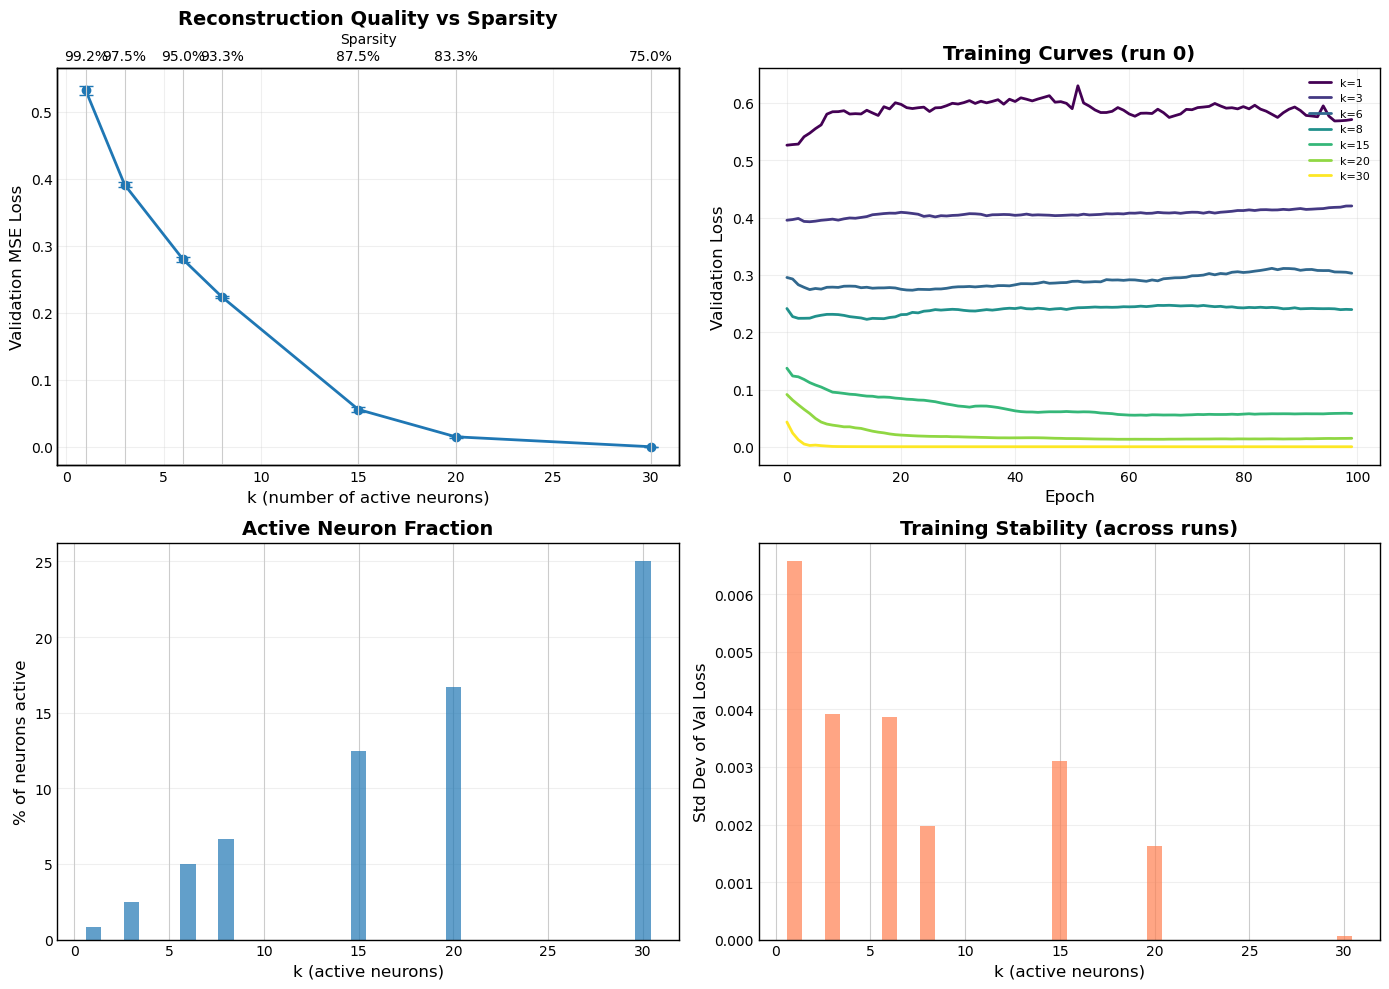


DETAILED ANALYSIS
k    Sparsity     Val Loss             Best Run   Worst Run 
----------------------------------------------------------------------
1     99.2%       0.5325 ± 0.0066    0.5245    0.5411
3     97.5%       0.3914 ± 0.0039    0.3879    0.3985
6     95.0%       0.2798 ± 0.0039    0.2732    0.2844
8     93.3%       0.2238 ± 0.0020    0.2220    0.2270
15    87.5%       0.0557 ± 0.0031    0.0512    0.0609
20    83.3%       0.0150 ± 0.0016    0.0133    0.0172
30    75.0%       0.0002 ± 0.0001    0.0001    0.0003

BEST MODEL: k=30 with validation loss 0.0002
Sparsity: 75.0%


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

model_dir = 'projects/laloo-sae/models/12_21_25'  # models directory in project root
k_values = [1, 3, 6, 8, 15, 20, 30]
hidden_dim = 120  # Based on 4x expansion of 30D input


# ============================================================================
# 1. Load Results Summary
# ============================================================================
results = torch.load(os.path.join(model_dir, 'training_summary.pkl'))

# Collect metrics across k values
k_vals = []
mean_losses = []
std_losses = []

for k in k_values:
    if len(results[k]) > 0:
        val_losses = [r['best_val_loss'] for r in results[k]]
        k_vals.append(k)
        mean_losses.append(np.mean(val_losses))
        std_losses.append(np.std(val_losses))

# ============================================================================
# 2. Plot: Val Loss vs k (main result)
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Val Loss vs k
ax = axes[0, 0]
ax.errorbar(k_vals, mean_losses, yerr=std_losses, marker='o', capsize=5, linewidth=2)
ax.set_xlabel('k (number of active neurons)', fontsize=12)
ax.set_ylabel('Validation MSE Loss', fontsize=12)
ax.set_title('Reconstruction Quality vs Sparsity', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
# Add sparsity percentages on secondary x-axis
ax2 = ax.twiny()
sparsity_pcts = [(1 - k/hidden_dim)*100 for k in k_vals]
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(k_vals)
ax2.set_xticklabels([f'{s:.1f}%' for s in sparsity_pcts])
ax2.set_xlabel('Sparsity', fontsize=10)

# ============================================================================
# 3. Plot: Training Curves for each k
# ============================================================================
ax = axes[0, 1]
colors = plt.cm.viridis(np.linspace(0, 1, len(k_values)))

for i, k in enumerate(k_values):
    # Load first run's history for each k
    try:
        history = torch.load(os.path.join(model_dir, f'training_history_k{k}_run0.pkl'))
        ax.plot(history['val_losses'], label=f'k={k}', color=colors[i], linewidth=2)
    except:
        continue

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Training Curves (run 0)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# ============================================================================
# 4. Plot: Dead Neurons Analysis
# ============================================================================
ax = axes[1, 0]

# We'll need to extract dead neuron info from histories
dead_neurons_final = []
for k in k_values:
    try:
        history = torch.load(os.path.join(model_dir, f'training_history_k{k}_run0.pkl'))
        # Dead neurons not saved in history, so we'll compute from model
        # Or just show a placeholder
        dead_neurons_final.append(0)  # Placeholder
    except:
        dead_neurons_final.append(0)

ax.bar(k_vals, [k/hidden_dim*100 for k in k_vals], alpha=0.7)
ax.set_xlabel('k (active neurons)', fontsize=12)
ax.set_ylabel('% of neurons active', fontsize=12)
ax.set_title('Active Neuron Fraction', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 5. Plot: Variance across runs (stability)
# ============================================================================
ax = axes[1, 1]
ax.bar(k_vals, std_losses, alpha=0.7, color='coral')
ax.set_xlabel('k (active neurons)', fontsize=12)
ax.set_ylabel('Std Dev of Val Loss', fontsize=12)
ax.set_title('Training Stability (across runs)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'training_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

## stats
print("\n" + "="*70)
print("DETAILED ANALYSIS")
print("="*70)
print(f"{'k':<4} {'Sparsity':<12} {'Val Loss':<20} {'Best Run':<10} {'Worst Run':<10}")
print("-"*70)

for k in k_values:
    if len(results[k]) > 0:
        val_losses = [r['best_val_loss'] for r in results[k]]
        mean_loss = np.mean(val_losses)
        std_loss = np.std(val_losses)
        min_loss = np.min(val_losses)
        max_loss = np.max(val_losses)
        sparsity_pct = (1 - k/hidden_dim)*100
        
        print(f"{k:<4} {sparsity_pct:>5.1f}%       "
              f"{mean_loss:.4f} ± {std_loss:.4f}    "
              f"{min_loss:.4f}    {max_loss:.4f}")

# Find best k
best_k = k_vals[np.argmin(mean_losses)]
best_loss = np.min(mean_losses)
print(f"\n{'='*70}")
print(f"BEST MODEL: k={best_k} with validation loss {best_loss:.4f}")
print(f"Sparsity: {(1-best_k/hidden_dim)*100:.1f}%")
print(f"{'='*70}")

In [ ]:
import os

k_values = [1, 3, 6, 8, 12, 15, 20, 30]
model_dir = "projects/laloo-sae/models/sweepk"  # Current directory
trained_models = {}

device = torch.device("cpu")

print("Loading models from disk...")
for k in k_values:
    filename = f"topksae_{k}.pt"
    filepath = os.path.join(model_dir, filename)
    
    if os.path.exists(filepath):
        # Initialize empty model
        model = TopKSAE(k=k).to(device)
        # Load weights
        model.load_state_dict(torch.load(filepath, map_location=device))
        model.eval() # Set to eval mode
        trained_models[k] = model
        print(f"  [+] Loaded k={k}")
    else:
        print(f"  [!] WARNING: File {filename} not found. You might need to retrain this one.")

print(f"\nReady! Loaded {len(trained_models)} models.")

Loading models from disk...
  [!] WARNING: File topksae_1.pt not found. You might need to retrain this one.
  [!] WARNING: File topksae_3.pt not found. You might need to retrain this one.
  [+] Loaded k=6
  [+] Loaded k=8
  [+] Loaded k=12
  [+] Loaded k=15
  [+] Loaded k=20
  [+] Loaded k=30

Ready! Loaded 6 models.


## Linear Probe


In [ ]:
from src.config import OUTPUT_DIR
from src.data_processor import load_processed_data

latents_normalized, metadata, stats = load_processed_data(OUTPUT_DIR)
# Extract the rmsd values from the metadata DataFrame
rmsd = metadata['rmsd'].values
energy = metadata['energy'].values

print(f"Loaded {len(metadata)} samples from {OUTPUT_DIR}")

Loaded 435,069 samples from processed_data
Loaded 435069 samples from ./processed_data


In [ ]:
# Linear Probe: Logistic Regression to Classify Bad Poses (RMSD >= 2.0 Å)

# 1. Define Target: 1 for Bad Pose, 0 for Good Pose
y_is_bad = (rmsd >= 2.0).astype(int)
print(f"Target Distribution:")
print(f"  Total Samples: {len(y_is_bad)}")
print(f"  Bad Poses (Class 1): {y_is_bad.sum()} ({y_is_bad.mean()*100:.1f}%)")
print(f"  Good Poses (Class 0): {(y_is_bad == 0).sum()} ({(1-y_is_bad.mean())*100:.1f}%)")

# Store results for table
probe_results = []

# BASELINE - RAW 30D LATENT VECTORS (not sae)
print(f"\nTraining Baseline (Raw 30D Latents)...")

# Split data (using random_state=42 ensures same split as SAE training)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    latents_normalized, y_is_bad, test_size=0.3, stratify=y_is_bad, random_state=42
)

# Train Logistic Regression
lr_raw = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_raw.fit(X_train_raw, y_train)

# Predict
y_val_pred_raw = lr_raw.predict_proba(X_val_raw)[:, 1]
aupr_raw = average_precision_score(y_val, y_val_pred_raw)

print(f"  -> Raw Latents Val auPR: {aupr_raw:.4f}")

probe_results.append({
    "Model": "Raw Latents (30D)",
    "k": "-",
    "Val auPR": aupr_raw,
    "Delta": 0.0
})

Target Distribution:
  Total Samples: 435069
  Bad Poses (Class 1): 381574 (87.7%)
  Good Poses (Class 0): 53495 (12.3%)

Training Baseline (Raw 30D Latents)...
  -> Raw Latents Val auPR: 0.9388


In [ ]:
## Linear Probes for non-Baseline

# Store results for table
probe_results = []

#SAE MODELS
print(f"\nTraining Linear Probes on SAE Features...")

for k in sorted(trained_models.keys()):
    # 1. Extract Features
    model = trained_models[k]
    model.eval()
    
    features_k = []
    all_latents_tensor = torch.FloatTensor(latents_normalized).to(device)
    with torch.no_grad():
        for i in range(0, len(all_latents_tensor), 256):
            batch_x = all_latents_tensor[i : i + 256]
            feats = model.get_acts(batch_x)
            features_k.append(feats.cpu().numpy())
    features_k = np.concatenate(features_k, axis=0)
    
    # 2. Split
    X_train_sae, X_val_sae, _, _ = train_test_split(
        features_k, y_is_bad, test_size=0.3, stratify=y_is_bad, random_state=42
    )
    
    # 3. Train Logistic Regression
    lr_sae = LogisticRegression(
        penalty='l1', solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')
    lr_sae.fit(X_train_sae, y_train)
    
    # Extract Top 3 "Bad Pose" Features
    weights = lr_sae.coef_[0]
    # Get indices of 3 largest weights
    top_3_indices = np.argsort(weights)[-3:][::-1] 
    top_3_weights = weights[top_3_indices]
    
    # Format them as a string for the table
    top_feats_str = ", ".join([f"#{idx} ({w:.2f})" for idx, w in zip(top_3_indices, top_3_weights)])
    # ----------------------------------------------
    
    # 4. Predict
    y_val_pred_sae = lr_sae.predict_proba(X_val_sae)[:, 1]
    aupr_sae = average_precision_score(y_val, y_val_pred_sae)
    
    print(f"  -> SAE (k={k}) Val auPR: {aupr_sae:.4f} | Top Features: {top_feats_str}")
    
    probe_results.append({
        "Model": "TopK SAE",
        "k": k,
        "Val auPR": aupr_sae,
        "Delta": aupr_sae - aupr_raw,
        "Top 3 Features (Weight)": top_feats_str
    })

# SUMMARY
print(f"\n{'='*90}")
print("BAD POSE CLASSIFICATION RESULTS")
print(f"{'='*90}")
df_probe = pd.DataFrame(probe_results)
df_probe = df_probe.sort_values("Val auPR", ascending=False)
# Display with wider column for the features
pd.set_option('display.max_colwidth', None)
print(df_probe.to_string(index=False))


Training Linear Probes on SAE Features...
  -> SAE (k=6) Val auPR: 0.9606 | Top Features: #1 (1.38), #51 (0.96), #55 (0.69)
  -> SAE (k=8) Val auPR: 0.9619 | Top Features: #21 (1.90), #4 (1.54), #6 (0.67)
  -> SAE (k=12) Val auPR: 0.9604 | Top Features: #25 (1.62), #99 (1.09), #58 (0.68)
  -> SAE (k=15) Val auPR: 0.9612 | Top Features: #36 (0.85), #41 (0.64), #61 (0.62)
  -> SAE (k=20) Val auPR: 0.9640 | Top Features: #111 (1.09), #75 (1.04), #1 (0.94)
  -> SAE (k=30) Val auPR: 0.9621 | Top Features: #19 (6.35), #31 (3.21), #57 (3.06)

BAD POSE CLASSIFICATION RESULTS
   Model  k  Val auPR    Delta            Top 3 Features (Weight)
TopK SAE 20  0.963970 0.025174 #111 (1.09), #75 (1.04), #1 (0.94)
TopK SAE 30  0.962092 0.023295 #19 (6.35), #31 (3.21), #57 (3.06)
TopK SAE  8  0.961934 0.023138   #21 (1.90), #4 (1.54), #6 (0.67)
TopK SAE 15  0.961194 0.022398 #36 (0.85), #41 (0.64), #61 (0.62)
TopK SAE  6  0.960600 0.021803  #1 (1.38), #51 (0.96), #55 (0.69)
TopK SAE 12  0.960412 0.02161

## Linear Probe Visualization

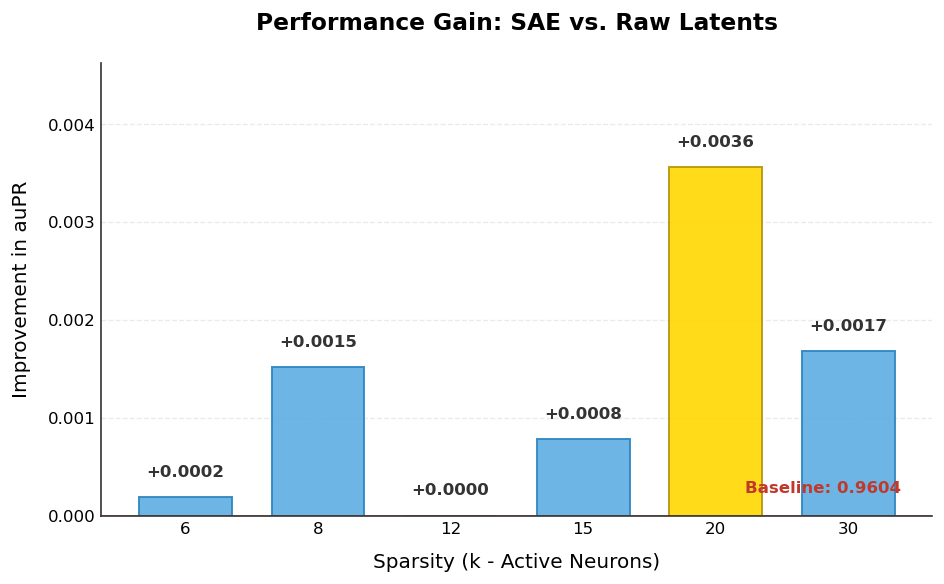

In [ ]:
def plot_probe_results(df_probe):
    """
    Takes the 'df_probe' DataFrame output from your Linear Probe cell
    and generates a publication-quality Delta plot.
    """
    
    # 1. Parse Data: Separate Baseline from SAE Results
    # Find the baseline row (where k is '-' or Model is 'Raw Latents')
    baseline_mask = df_probe['Model'].str.contains("Raw Latents")
    if baseline_mask.any():
        baseline_aupr = df_probe.loc[baseline_mask, 'Val auPR'].values[0]
    else:
        # Fallback if baseline row is missing
        print("Warning: Baseline row not found in dataframe. Using min value as proxy.")
        baseline_aupr = df_probe['Val auPR'].min()

    # Filter for SAE results only
    df_sae = df_probe[~baseline_mask].copy()
    
    # Ensure k is numeric and sorted
    df_sae['k'] = pd.to_numeric(df_sae['k'])
    df_sae = df_sae.sort_values('k')
    
    # Recalculate Delta just to be safe (SAE - Baseline)
    df_sae['delta_plot'] = df_sae['Val auPR'] - baseline_aupr

    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.edgecolor': '#333333',
        'grid.color': '#dddddd',
        'grid.linestyle': '--',
        'grid.alpha': 0.6,
        'figure.dpi': 120
    })

    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plotting Logic - identify best k (max auPR)
    best_k = df_sae.loc[df_sae['Val auPR'].idxmax(), 'k']
    
    # Color mapping: Gold for Best, Slate Blue for others
    colors = ['#FFD700' if x == best_k else '#5DADE2' for x in df_sae['k']]
    edge_colors = ['#B7950B' if x == best_k else '#2E86C1' for x in df_sae['k']]
    
    # Draw Bars
    bars = ax.bar(df_sae['k'].astype(str), df_sae['delta_plot'], color=colors, 
                  edgecolor=edge_colors, linewidth=1.2, alpha=0.9, width=0.7)
    
    # Draw Baseline Line at 0
    ax.axhline(0, color='#E74C3C', linewidth=1.5, linestyle='-', alpha=0.8)
    ax.text(len(df_sae)-0.6, 0.0002, f"Baseline: {baseline_aupr:.4f}", color='#C0392B', 
            ha='right', va='bottom', fontweight='bold', fontsize=10)
    
    # 4. Labels & Text
    ax.set_title('Performance Gain: SAE vs. Raw Latents', fontweight='bold', pad=20)
    ax.set_xlabel('Sparsity (k - Active Neurons)', labelpad=10)
    ax.set_ylabel('Improvement in auPR', labelpad=10)
    
    # Add "+0.0048" text on top of bars
    y_offset = df_sae['delta_plot'].max() * 0.05
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                 f'+{height:.4f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')
    
    # Adjust y-limits for breathing room
    ax.set_ylim(0, df_sae['delta_plot'].max() * 1.3)
    
    # Grid configuration
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    plt.tight_layout()
    plt.show()

plot_probe_results(df_probe)

## Feature Extraction and Analysis for Best Model (k=6): RMSD & Energy

Extracting features for k=20...

SHARED FEATURE ANALYSIS (k=20)
Top 10 RMSD Features:   [ 87  85 100  55  10  44  15  12  45  20]
Top 10 Energy Features: [ 37  36  49  52  14 118  61 107 100  66]
Shared Features:        [100]


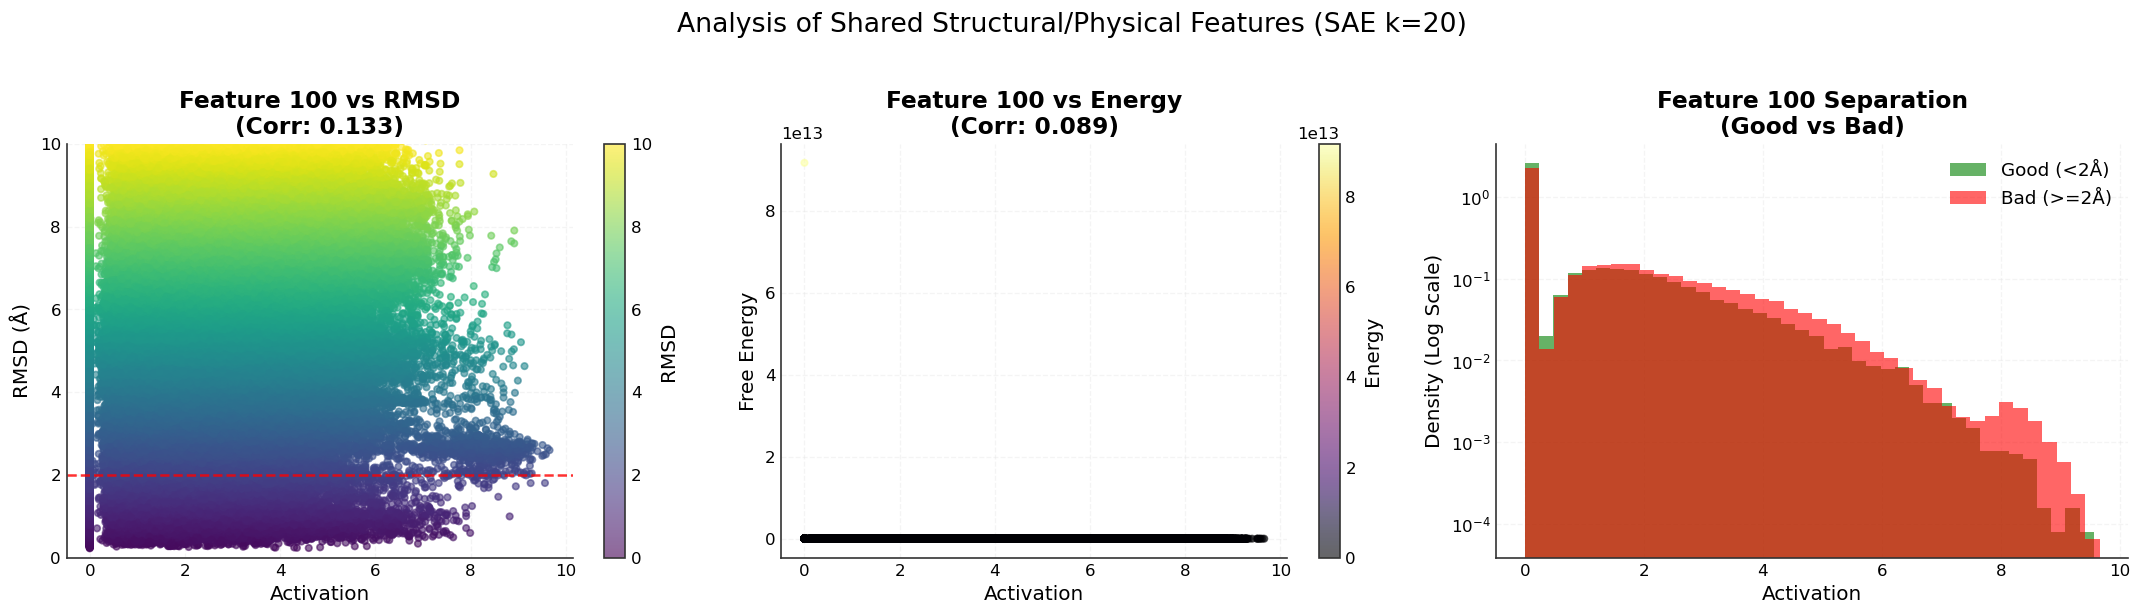

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from scipy.stats import spearmanr

def visualize_shared_features(trained_models, latents_normalized, rmsd, energy, device):
    """
    Analyzes and visualizes features that correlate with both RMSD and Free Energy.
    """
    
    # 1. Setup Data for Best Model (k=20) with good combo of mse loss and sparsity
    k_best = 20
    if k_best not in trained_models:
        k_best = list(trained_models.keys())[0]

    model = trained_models[k_best]
    model.eval()

    print(f"Extracting features for k={k_best}...")
    all_features_best = []
    all_latents_tensor = torch.FloatTensor(latents_normalized).to(device)

    with torch.no_grad():
        for i in range(0, len(all_latents_tensor), 256):
            batch_x = all_latents_tensor[i : i + 256]
            feats = model.get_acts(batch_x)
            all_features_best.append(feats.cpu().numpy())

    all_features_best = np.concatenate(all_features_best, axis=0)

    # 2. Calculate Correlations
    rmsd_corrs = []
    energy_corrs = []

    for i in range(all_features_best.shape[1]):
        r_c, _ = spearmanr(all_features_best[:, i], rmsd)
        e_c, _ = spearmanr(all_features_best[:, i], energy)
        rmsd_corrs.append(r_c)
        energy_corrs.append(e_c)

    rmsd_corrs = np.array(rmsd_corrs)
    energy_corrs = np.array(energy_corrs)

    # 3. Find Intersection (Top 10)
    top_n = 10
    top_rmsd_indices = np.argsort(np.abs(rmsd_corrs))[::-1][:top_n]
    top_energy_indices = np.argsort(np.abs(energy_corrs))[::-1][:top_n]
    shared_features = np.intersect1d(top_rmsd_indices, top_energy_indices)

    print(f"\n{'='*60}")
    print(f"SHARED FEATURE ANALYSIS (k={k_best})")
    print(f"{'='*60}")
    print(f"Top 10 RMSD Features:   {top_rmsd_indices}")
    print(f"Top 10 Energy Features: {top_energy_indices}")
    print(f"Shared Features:        {shared_features}")

    if len(shared_features) == 0:
        print("No shared features found in Top 10. Showing top RMSD feature instead.")
        shared_features = [top_rmsd_indices[0]]

    # 4. Visualizations for Shared Features
    # Plot up to 3 shared features
    feats_to_plot = shared_features[:3]
    is_bad = rmsd >= 2.0

    fig, axes = plt.subplots(len(feats_to_plot), 3, figsize=(18, 5 * len(feats_to_plot)))
    if len(feats_to_plot) == 1: axes = axes[None, :] # Ensure 2D array for indexing

    for row, idx in enumerate(feats_to_plot):
        # A. Scatter vs RMSD
        ax = axes[row, 0]
        # vmin/vmax ensures the color gradient focuses on the 0-10 range
        im = ax.scatter(all_features_best[:, idx], rmsd, 
                        c=rmsd, cmap='viridis', alpha=0.6, s=15, vmin=0, vmax=10)
        ax.set_xlabel('Activation')
        ax.set_ylabel('RMSD (Å)')
        ax.set_title(f'Feature {idx} vs RMSD\n(Corr: {rmsd_corrs[idx]:.3f})', fontweight='bold')
        
        # Limit Y-axis to 10 Angstroms to ignore outliers
        ax.set_ylim(0, 10)
        
        ax.axhline(2.0, color='red', linestyle='--', alpha=0.8, label='2.0 Å Threshold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(im, ax=ax, label='RMSD')

        # B. Scatter vs Energy
        ax = axes[row, 1]
        im = ax.scatter(all_features_best[:, idx], energy, 
                        c=energy, cmap='inferno', alpha=0.6, s=15)
        ax.set_xlabel('Activation')
        ax.set_ylabel('Free Energy')
        ax.set_title(f'Feature {idx} vs Energy\n(Corr: {energy_corrs[idx]:.3f})', fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(im, ax=ax, label='Energy')

        # C. Histogram (Good vs Bad)
        ax = axes[row, 2]
        feat_vals = all_features_best[:, idx]
        ax.hist(feat_vals[~is_bad], bins=40, alpha=0.6, label='Good (<2Å)', 
                color='green', density=True, log=True)
        ax.hist(feat_vals[is_bad], bins=40, alpha=0.6, label='Bad (>=2Å)', 
                color='red', density=True, log=True)
        ax.set_xlabel('Activation')
        ax.set_ylabel('Density (Log Scale)')
        ax.set_title(f'Feature {idx} Separation\n(Good vs Bad)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Analysis of Shared Structural/Physical Features (SAE k={k_best})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_shared_features(trained_models, latents_normalized, rmsd, energy, device)

### Feature + Structure Visualization

In [ ]:
def get_top_activating_poses(model_k, feature_idx, n=5):
    model = trained_models[model_k]
    model.eval()
    
    # Get activations for all data
    all_latents_tensor = torch.FloatTensor(latents_normalized).to(device)
    with torch.no_grad():
        # Using the encode method from your model.py
        acts, _, _ = model.encode(all_latents_tensor)
        feature_acts = acts[:, feature_idx].cpu().numpy()
    
    # Get indices of the top N activating poses
    top_indices = np.argsort(feature_acts)[-n:][::-1]
    
    print(f"Top {n} Poses for Feature #{feature_idx} (k={model_k}):")
    for i, idx in enumerate(top_indices):
        pose_info = metadata.iloc[idx]
        print(f"  {i+1}. Index: {idx} | Activation: {feature_acts[idx]:.2f} | RMSD: {pose_info['rmsd']:.2f} | Case: {pose_info['case_id']}")
    
    return top_indices

# Look at strongest predictor from the k=8 model
top_poses_21 = get_top_activating_poses(20, 111)

Top 5 Poses for Feature #111 (k=20):
  1. Index: 224961 | Activation: 2.35 | RMSD: 8.11 | Case: mdm2_3jzk_mdm2_4zyf
  2. Index: 224803 | Activation: 2.35 | RMSD: 7.55 | Case: mdm2_3jzk_mdm2_4zyf
  3. Index: 225509 | Activation: 2.35 | RMSD: 10.31 | Case: mdm2_3jzk_mdm2_4zyf
  4. Index: 226020 | Activation: 2.11 | RMSD: 5.87 | Case: mdm2_3jzk_mdm2_4zyf
  5. Index: 226222 | Activation: 2.11 | RMSD: 5.91 | Case: mdm2_3jzk_mdm2_4zyf


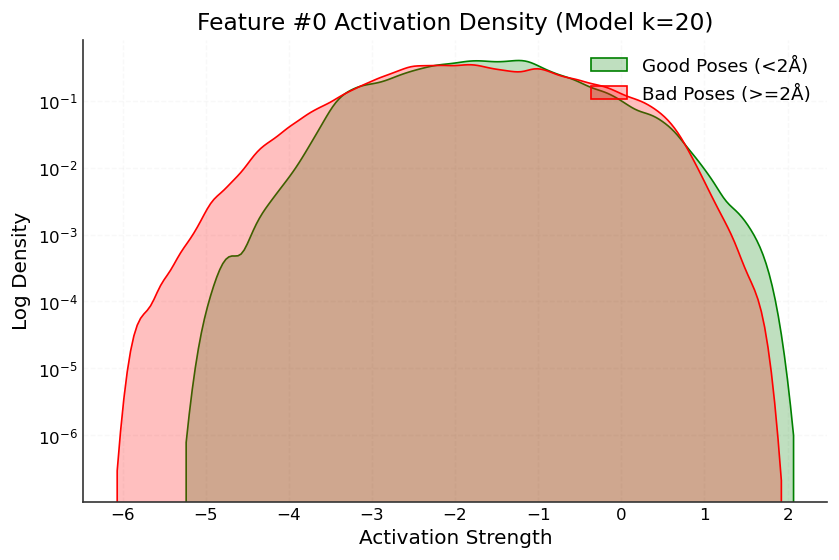

In [178]:
def plot_feature_separation(model_k, feature_idx):
    model = trained_models[model_k]
    all_latents_tensor = torch.FloatTensor(latents_normalized).to(device)
    
    with torch.no_grad():
        acts, _, _ = model.encode(all_latents_tensor)
        f_acts = acts[:, feature_idx].cpu().numpy()
    
    plt.figure(figsize=(8, 5))
    
    # Plot Good vs Bad distributions
    sns.kdeplot(f_acts[rmsd < 2.0], fill=True, label='Good Poses (<2Å)', color='green', log_scale=(False, True))
    sns.kdeplot(f_acts[rmsd >= 2.0], fill=True, label='Bad Poses (>=2Å)', color='red', log_scale=(False, True))
    
    plt.title(f"Feature #{feature_idx} Activation Density (Model k={model_k})")
    plt.xlabel("Activation Strength")
    plt.ylabel("Log Density")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

plot_feature_separation(20, 0)